## Librerias

In [1]:
import numpy as np                          # Operaciones numéricas eficientes en matrices
import pandas as pd                         # Estructuras y análisis de datos tabulares
import json                                 # Manipulación de objetos JSON
import jsonlines                            # Lectura y escritura de archivos JSON en formato de líneas
from sklearn.compose import ColumnTransformer  # Transformaciones de columnas en un estimador de flujo de trabajo
from sklearn.preprocessing import OneHotEncoder  # Codificación one-hot para variables categóricas
from sklearn.preprocessing import StandardScaler  # Escalado de características
from sklearn.compose import make_column_selector  # Selector de columnas basado en tipos de datos
from sklearn.pipeline import Pipeline       # Construcción de canalizaciones de transformación y modelado
from sklearn.impute import SimpleImputer    # Imputación de valores faltantes
from sklearn import preprocessing          # Preprocesamiento de datos
import imblearn                            # Técnicas de remuestreo y equilibrio de clases
import matplotlib.pyplot as plt            # Creación de gráficos y visualización de datos
import xgboost as xgb                       # Implementación de algoritmos de XGBoost
from xgboost import XGBClassifier          # Clasificador XGBoost
from sklearn.model_selection import train_test_split  # División de datos en conjuntos de entrenamiento y prueba
from sklearn.preprocessing import LabelEncoder       # Codificación de etiquetas
from sklearn.metrics import average_precision_score  # Cálculo del promedio de precisión
from scipy import stats                     # Funciones estadísticas y matemáticas avanzadas
from sklearn.metrics import roc_curve, mean_squared_error, roc_auc_score, precision_score  # Métricas de evaluación
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
from sklearn.metrics import fbeta_score, make_scorer, f1_score
from sklearn.model_selection import train_test_split  # División de datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import GridSearchCV     # Búsqueda exhaustiva de hiperparámetros en cuadrícula
from sklearn.model_selection import StratifiedKFold   # División estratificada de datos para validación cruzada
from sklearn.model_selection import RandomizedSearchCV  # Búsqueda aleatoria de hiperparámetros
import time                                    # Funciones relacionadas con el tiempo
from sklearn.preprocessing import StandardScaler  # Escalado de características
from sklearn.linear_model import LogisticRegression  # Regresión logística
from sklearn.tree import DecisionTreeClassifier       # Árbol de decisión
from sklearn.svm import SVC                           # Máquinas de vectores de soporte
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
import sys
sys.path.append('C:/Users/medinaj/OneDrive - SierraCol Energy/sierracol_2022/Meli_J/challenge-ml/')

In [3]:
from data.raw.new_or_used import build_dataset
from data.processed.seller_address_transformer import SellerAddressTransformer
from data.processed.shipping_transformer import ShippingTransformer
from data.processed.tags_transformer import TagsTransformer
from data.processed.payment_methods_transformer import PaymentMethodsTransformer
from data.processed.warranty_transformer import WarrantyTransformer

## Cargar Dataset

In [4]:
# Obtener los datos
X_train, y_train, X_test, y_test = build_dataset()

# Convertir en dataframes
df_X_train = pd.DataFrame(X_train)
df_X_test = pd.DataFrame(X_test)
df_y_train = pd.DataFrame({"condition": y_train})
df_y_test = pd.DataFrame({"condition": y_test})

In [5]:
# Assign 'id' column for df_X_train from 1 to 90,000
df_X_train['id'] = range(1, len(df_X_train) + 1)

# Assign 'id' column for df_X_test from 1 to 10,000
df_X_test['id'] = range(1, len(df_X_test) + 1)


# Añadir df_y_test al df_X_test
df_X_test['condition'] = df_y_test

# Selecting the relevant columns
df_nlp = df_X_train[['id', 'condition', 'title']]
df_nlp_test = df_X_test[['id', 'condition', 'title']]

In [6]:
df_nlp_train_test = pd.concat([df_nlp, df_nlp_test], axis=0)

# Add a new column to label each row as either 'train' or 'test'
df_nlp_train_test['dataset'] = ['train'] * len(df_nlp) + ['test'] * len(df_nlp_test)

# If you want, you can also save the combined dataframe to CSV
df_nlp_train_test.to_csv('df_nlp_train_test.csv', sep='|', encoding='utf-8-sig', index=False)

In [7]:
df_save_category = pd.read_csv('C:\\Users\\medinaj\\OneDrive - SierraCol Energy\\sierracol_2022\\Meli_J\\challenge-ml\\data\\processed\\df_save.csv', sep='|')

In [8]:
df_save_category.head()

,id,Document,Category,dataset,ClusterLabel
0,1,Auriculares Samsung Originales Manos Libres Ca...,nuevo,train,1
1,2,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,usado,train,1
2,3,"Antigua Revista Billiken, N° 1826, Año 1954",usado,train,0
3,4,Alarma Guardtex Gx412 Seguridad Para El Automo...,nuevo,train,1
4,5,Serenata - Jennifer Blake,usado,train,0


In [9]:
# Filtrar df_save_category
df_save_category_train = df_save_category[df_save_category['dataset'] == 'train']
df_save_category_test = df_save_category[df_save_category['dataset'] == 'test']

# Merge con df_X_train
df_X_train = pd.merge(df_X_train, df_save_category_train, on='id', how='left')
df_X_test = pd.merge(df_X_test, df_save_category_test, on='id', how='left')


## Limpieza y depuración del dataset

In [10]:
def process_dataframe(df):
    sat = SellerAddressTransformer()
    st = ShippingTransformer()
    tt = TagsTransformer()
    pmt = PaymentMethodsTransformer()
    wt = WarrantyTransformer() 
    
    # Apply transformations and get processed DataFrames
    seller_address_normalized = sat.transform(df)
    shipping_normalized = st.transform(df)
    df = tt.transform(df)
    df = pmt.transform(df)
    df["warranty"] = df["warranty"].apply(wt.transform)


    # Calculo de la columna 'listing_type_id'
    mapeo = {'bronze': 'bronze', 'free': 'free', 'silver': 'silver', 'gold_special': 'superior',
             'gold': 'superior', 'gold_premium': 'superior', 'gold_pro': 'superior'}
    df['listing_type2'] = df['listing_type_id'].replace(mapeo)
    df['listing_type'] = df['listing_type2'].replace({'bronze': 1, 'free': 0, 'superior': 3, 'silver': 2})

      # Calculo de las columnas de fechas
    date_columns = ['last_updated', 'date_created']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])
        df[col] = df[col].dt.tz_localize(None)
        df[f'days_{col}'] = (pd.Timestamp.now().normalize() - df[col].dt.normalize()).dt.days

    # Calculo de las columnas de fechas
    date_columns = ['stop_time', 'start_time']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col],format='%Y-%m-%d %H:%M:%S')
        df[col] = df[col].dt.tz_localize(None)
        df[f'days_{col}'] = (pd.Timestamp.now().normalize() - df[col].dt.normalize()).dt.days

    # Calculo de la columna 'dif_vendidos'
    df['dif_vendidos'] = df['available_quantity'] - df['sold_quantity']

   # Eliminar columnas innecesarias
    cols_delete = ['seller_address', 'sub_status', 'deal_ids',
       'shipping', 'non_mercado_pago_payment_methods',
       'seller_id', 'variations', 'site_id', 'listing_type_id', 
       'attributes', 'buying_mode', 'tags', 'listing_source', 'parent_item_id',
       'coverage_areas', 'category_id', 'descriptions', 'last_updated',
       'international_delivery_mode', 'pictures', 'id', 'official_store_id',
       'differential_pricing', 'accepts_mercadopago', 'original_price',
       'currency_id', 'thumbnail', 'title', 'automatic_relist', 'date_created',
       'secure_thumbnail', 'stop_time', 'status', 'video_id',
       'catalog_product_id', 'subtitle', 'start_time',
       'permalink','listing_type_id','listing_type2','base_price','initial_quantity',
       'non_mercado_pago_payment_methods_count2','available_quantity','days_stop_time', 'days_start_time',
       'seller_contact', 'location' , 'geolocation', 'Document', 'Category', 'dataset']
    
    df = df.drop(columns=cols_delete, errors='ignore') 

    df=pd.concat([df,seller_address_normalized['seller_address_stateid']
                      ], axis=1)

    return df

In [11]:
X_train1 = process_dataframe(df_X_train)
X_train1 = X_train1.drop(columns=['condition'])
X_test1 = process_dataframe(df_X_test)
X_test1 = X_test1.drop(columns=['condition'])

C:\Users/medinaj/OneDrive - SierraCol Energy/sierracol_2022/Meli_J/challenge-ml\data\processed\tags_transformer.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  expanded_tags = df['tags'].apply(pd.Series).add_suffix('_tags')
C:\Users/medinaj/OneDrive - SierraCol Energy/sierracol_2022/Meli_J/challenge-ml\data\processed\tags_transformer.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  expanded_tags = df['tags'].apply(pd.Series).add_suffix('_tags')


## Encoding

In [12]:
# Creamos las variables binarias
df_dummies = pd.get_dummies(X_train1['seller_address_stateid'], drop_first=True)
df_dummies = df_dummies.rename(columns={'AR-C': 'seller_address_stateid_AR-C','OTHER': 'seller_address_stateid_OTHER'})
X_train1 = X_train1.drop(columns=['seller_address_stateid'])
X_train1 = pd.concat([X_train1,df_dummies],axis=1)

In [13]:
# Creamos las variables binarias
df_dummies2 = pd.get_dummies(X_test1['seller_address_stateid'], drop_first=True)
df_dummies2 = df_dummies2.rename(columns={'AR-C': 'seller_address_stateid_AR-C','OTHER': 'seller_address_stateid_OTHER'})
X_test1 = X_test1.drop(columns=['seller_address_stateid'])
X_test1 = pd.concat([X_test1,df_dummies2],axis=1)

### Estandarización de Variables Numericas

In [14]:
num_cols = ['price', 'sold_quantity','non_mercado_pago_payment_methods_count','listing_type',
            'days_last_updated', 'days_date_created', 'dif_vendidos',]
dum_cols = ['tags_dragged_bids_and_visits','shipping_local_pick_up','shipping_mode_me2',
            'seller_address_stateid_AR-C','seller_address_stateid_OTHER']

In [15]:
scaler = StandardScaler()
X_train1[num_cols] = scaler.fit_transform(X_train1[num_cols])
X_test1[num_cols] = scaler.transform(X_test1[num_cols])

### Binarizando la variable de respuesta

In [16]:
y_train_dummy = pd.get_dummies(df_y_train)
y_test_dummy = pd.get_dummies(df_y_test)

In [17]:
# Referencia 'condition_new' = 1 --> Nuevo
y_train = y_train_dummy['condition_new']
y_test = y_test_dummy['condition_new']

## Verificación Datos Balanceados

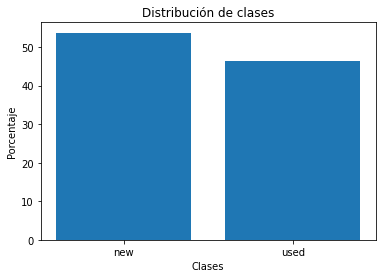

In [18]:
class_counts = df_y_train['condition'].value_counts()
class_percentages = class_counts / len(df_y_train) * 100

plt.bar(class_counts.index, class_percentages)
plt.xlabel('Clases')
plt.ylabel('Porcentaje')
plt.title('Distribución de clases')
plt.show()

Los datos no se encuentran desbalanceados por tanto proseguimos a entrenar un modelo de aprendizaje automatico.

## Entrenamiento de Modelos

## Regresión Logística

In [19]:
from ml_model.regression_log import LogisticRegressionModel

In [20]:
# Uso de la clase:
logistic_regression_model = LogisticRegressionModel()

# Entrenamiento
logistic_regression_model.train(X_train1, y_train)

# Evaluación
accuracy = logistic_regression_model.evaluate(X_test1, y_test)
print("Accuracy (Regresión Logística): {:.2f}".format(accuracy))

Accuracy (Regresión Logística): 0.78


### Nuevo Modelo de Regresión Logística con ajuste de Hiperparámetros

In [35]:
# Definir los hiperparámetros a ajustar y sus posibles valores
#param_grid = {
#    'C': [0.1, 1, 10],
#    'penalty': ['l1', 'l2'],
#    'solver': ['liblinear', 'saga']
#}

# Realizar la búsqueda exhaustiva de cuadrícula (Grid Search)
#grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5, scoring='accuracy')
#grid_search.fit(X_train1, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba utilizando el mejor modelo
#y_pred = best_model.predict(X_test1)

# Calcular la precisión del modelo
#accuracy = accuracy_score(y_test, y_pred)
#print("Precisión:", accuracy)

# Imprimir los mejores hiperparámetros encontrados
#print("Mejores hiperparámetros:", best_params)

c:\Users\medinaj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\medinaj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\medinaj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\medinaj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\medinaj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

In [ ]:
# Definir los hiperparámetros a ajustar y sus posibles valores
#param_grid = {
#    'C': [0.1, 1, 10],
#    'penalty': ['l1', 'l2'],
#    'solver': ['liblinear', 'saga']
#}

# Crear una instancia del modelo de regresión logística
#logistic_regression = LogisticRegression(max_iter=1000)

# Realizar la búsqueda exhaustiva de cuadrícula (Grid Search)
#grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo con la búsqueda de cuadrícula
#grid_search.fit(X_train1, y_train)  # Reemplaza X e y con tus datos de entrenamiento

# Imprimir los mejores hiperparámetros encontrados
#print("Mejores hiperparámetros encontrados:")
#print(grid_search.best_params_)

# Imprimir la mejor puntuación obtenida
#print("Mejor puntuación del modelo:")
#print(grid_search.best_score_)

Este modelo no corrio.

### Eliminación recursiva de variables en Regresión Logística

In [42]:
# Crear el modelo de regresión logística
#model3 = LogisticRegression()

# Crear el objeto RFE y especificar el número de características a seleccionar
#rfe = RFE(estimator=model3, n_features_to_select=5)  # Ajusta el valor de n_features_to_select según tus necesidades

# Aplicar la Eliminación Recursiva de Características
#rfe.fit(X_train1, y_train)

# Obtener las características seleccionadas
#selected_features = X_train1.columns[rfe.support_]

# Imprimir las características seleccionadas
#print("Características seleccionadas:")
#print(selected_features)

Características seleccionadas:
Index(['sold_quantity', 'listing_type', 'dif_vendidos',
       'shipping_local_pick_up', 'seller_address_stateid_OTHER'],
      dtype='object')


### Ajustar nuevamente un modelo de Regresión Logística

In [44]:
# Crear el modelo de regresión logística
#model_red1 = LogisticRegression()

# Entrenar el modelo utilizando solo las características seleccionadas
#model_red1.fit(X_train1[selected_features], y_train)

# Realizar predicciones en el conjunto de prueba utilizando solo las características seleccionadas
#y_pred = model_red1.predict(X_test1[selected_features])

# Calcular las métricas del modelo
#accuracy = accuracy_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)

# Imprimir las métricas del modelo
#print("Precisión:", accuracy)
#print("Precisión:", precision)
#print("Recall:", recall)
#print("F1-score:", f1)

Precisión: 0.7234
Precisión: 0.6887871853546911
Recall: 0.8908620051794303
F1-score: 0.7768994999193419


In [27]:
# Crear el modelo
#logistic_regression = LogisticRegression()

# Entrenar el modelo
#logistic_regression.fit(X_train2, y_train)

# Evaluar el modelo
#accuracy = logistic_regression.score(X_test2, y_test)
#print("Accuracy (Regresión Logística): {:.2f}".format(accuracy))

El mejor modelo de regresión logística encontrado fue de un accuracy de 0.78

## Decision Tree

In [21]:
# Crear el modelo
decision_tree = DecisionTreeClassifier()

# Entrenar el modelo
decision_tree.fit(X_train1, y_train)

# Evaluar el modelo
accuracy = decision_tree.score(X_test1, y_test)
print("Accuracy (Árboles de Decisión): {:.2f}".format(accuracy))

Accuracy (Árboles de Decisión): 0.80


## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train1, y_train)
y_pred = model.predict(X_test1)
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (Random Forest): {:.2f}".format(accuracy))

Accuracy (Random Forest): 0.85


## XGBoost Classifier

In [23]:
# Crear el clasificador de XGBoost
model = xgb.XGBClassifier()

# Entrenar el modelo
model.fit(X_train1, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test1)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (XGBoost Classifier): {:.2f}".format(accuracy))

Accuracy (XGBoost Classifier): 0.86


Como el resultado del algoritmo XGBoost es el más cercano al accuracy buscado, nos quedamos con este método y realizamos una busqueda de hiperparametros optimos:

In [24]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint

# Definir los rangos de valores para los hiperparámetros a ajustar
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 500),
}

# Crear el clasificador de XGBoost
model = xgb.XGBClassifier()

# Realizar la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring='accuracy',
    n_iter=10,
    cv=5,
    random_state=42
)
random_search.fit(X_train1, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test1)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo con los mejores hiperparámetros (XGBoost Classifier): {:.2f}".format(accuracy))

Precisión del modelo con los mejores hiperparámetros (XGBoost Classifier): 0.86


Este fue el mejor modelo de todos los evaluados.

In [25]:
model.fit(X_train1, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Validamos la importancia de cada variable en el modelo:

In [26]:
importance_scores = model.feature_importances_
variables = X_train1.columns
# Asociar cada variable con su valor de importancia
variable_importance = zip(variables, importance_scores)

# Imprimir la asociación entre variables y valores de importancia
for variable, importance in variable_importance:
    print(f'Variable: {variable}, Importancia: {importance}')

Variable: warranty, Importancia: 0.037722114473581314
Variable: price, Importancia: 0.021380025893449783
Variable: sold_quantity, Importancia: 0.16401046514511108
Variable: ClusterLabel, Importancia: 0.13073399662971497
Variable: shipping_local_pick_up, Importancia: 0.008248550817370415
Variable: shipping_mode_me2, Importancia: 0.01954195834696293
Variable: tags_dragged_bids_and_visits, Importancia: 0.03108026087284088
Variable: non_mercado_pago_payment_methods_count, Importancia: 0.011693105101585388
Variable: listing_type, Importancia: 0.3648748993873596
Variable: days_last_updated, Importancia: 0.006582980044186115
Variable: days_date_created, Importancia: 0.007110270671546459
Variable: dif_vendidos, Importancia: 0.18060441315174103
Variable: seller_address_stateid_AR-C, Importancia: 0.007777045946568251
Variable: seller_address_stateid_OTHER, Importancia: 0.008639848791062832


Como se observa que las variables: seller_address_stateid_AR-C y seller_address_stateid_OTHER, days_last_updated, days_date_created tienen una importancia relativamente baja, se valida como queda el modelamiento con estos ajustes.

In [27]:
X_train1.columns

Index(['warranty', 'price', 'sold_quantity', 'ClusterLabel',
       'shipping_local_pick_up', 'shipping_mode_me2',
       'tags_dragged_bids_and_visits',
       'non_mercado_pago_payment_methods_count', 'listing_type',
       'days_last_updated', 'days_date_created', 'dif_vendidos',
       'seller_address_stateid_AR-C', 'seller_address_stateid_OTHER'],
      dtype='object')

### XGBoost Classifier (Eliminando variables de menos importancia)

In [28]:
X_train2 = X_train1.drop(columns=['seller_address_stateid_AR-C',
                                  'seller_address_stateid_OTHER',
                                  'days_last_updated',
                                  'days_date_created',
                                  'shipping_local_pick_up'])

In [29]:
X_test2 = X_test1.drop(columns=['seller_address_stateid_AR-C',
                                  'seller_address_stateid_OTHER',
                                  'days_last_updated',
                                  'days_date_created',
                                  'shipping_local_pick_up'])

In [30]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint

# Definir los rangos de valores para los hiperparámetros a ajustar
param_dist2 = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 500),
}

# Crear el clasificador de XGBoost
model2 = xgb.XGBClassifier()

# Realizar la búsqueda aleatoria
random_search2 = RandomizedSearchCV(
    estimator=model2,
    param_distributions=param_dist2,
    scoring='accuracy',
    n_iter=10,
    cv=5,
    random_state=42
)
random_search2.fit(X_train2, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
best_params2 = random_search2.best_params_
best_model2 = random_search2.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred2 = best_model2.predict(X_test2)

# Calcular la precisión del modelo
accuracy2 = accuracy_score(y_test, y_pred)
print("Precisión del modelo con los mejores hiperparámetros (XGBoost Classifier): {:.2f}".format(accuracy2))

Precisión del modelo con los mejores hiperparámetros (XGBoost Classifier): 0.86


In [31]:
model2.fit(X_train2, y_train)

importance_scores = model2.feature_importances_
variables = X_train2.columns
# Asociar cada variable con su valor de importancia
variable_importance = zip(variables, importance_scores)

# Imprimir la asociación entre variables y valores de importancia
for variable, importance in variable_importance:
    print(f'Variable: {variable}, Importancia: {importance}')

Variable: warranty, Importancia: 0.048690278083086014
Variable: price, Importancia: 0.030853739008307457
Variable: sold_quantity, Importancia: 0.13232780992984772
Variable: ClusterLabel, Importancia: 0.1467839777469635
Variable: shipping_mode_me2, Importancia: 0.02232552319765091
Variable: tags_dragged_bids_and_visits, Importancia: 0.03974030539393425
Variable: non_mercado_pago_payment_methods_count, Importancia: 0.011028752662241459
Variable: listing_type, Importancia: 0.3852717876434326
Variable: dif_vendidos, Importancia: 0.18297776579856873


In [32]:
X_train2 = X_train1.drop(columns=['seller_address_stateid_AR-C',
                                  'seller_address_stateid_OTHER',
                                  'days_last_updated',
                                  'days_date_created',
                                  'shipping_local_pick_up'])
X_test2 = X_test1.drop(columns=['seller_address_stateid_AR-C',
                                  'seller_address_stateid_OTHER',
                                  'days_last_updated',
                                  'days_date_created',
                                  'shipping_local_pick_up'])

### Evaluando multiples modelos

In [2]:
#pip install pycaret

In [33]:
train_df = pd.concat([X_train1,y_train],axis=1)
test_df = pd.concat([X_test1,y_test],axis=1)

In [34]:
from pycaret.classification import *

# Configurar el experimento con los conjuntos de entrenamiento y prueba
exp = setup(data=train_df, test_data=test_df, target='condition_new', session_id=123, index=False)

,Description,Value
0,Session id,123
1,Target,condition_new
2,Target type,Binary
3,Original data shape,"(100000, 15)"
4,Transformed data shape,"(100000, 15)"
5,Transformed train set shape,"(90000, 15)"
6,Transformed test set shape,"(10000, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


In [35]:
# Comparar modelos y seleccionar el mejor
best_model = compare_models()

# Ajustar el modelo seleccionado
tuned_model = tune_model(best_model)

# Evaluar el modelo en el conjunto de prueba
predictions = predict_model(tuned_model, data=test_df)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7186,0.9335,0.9839,0.6596,0.7898,0.4106,0.4928
1,0.7144,0.9321,0.9843,0.6562,0.7874,0.4015,0.4859
2,0.7139,0.9308,0.9820,0.6562,0.7867,0.4006,0.4831
3,0.7183,0.9306,0.9866,0.6588,0.7901,0.4099,0.4947
4,0.7132,0.9286,0.9806,0.6559,0.7860,0.3993,0.4808
5,0.7189,0.9338,0.9824,0.6602,0.7897,0.4115,0.4923
6,0.7260,0.9346,0.9857,0.6654,0.7945,0.4267,0.5075
7,0.7151,0.9363,0.9845,0.6566,0.7878,0.4031,0.4873
8,0.7201,0.9336,0.9830,0.6611,0.7905,0.4142,0.4950


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8580,0.9374,0.8526,0.8809,0.8665,0.7149,0.7154


In [36]:
best_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)